In [1]:
import pandas as pd
import numpy as np
import keras
from keras import utils
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import plotly.plotly as plotly
import plotly.graph_objs as go
from IPython.display import Image

Using TensorFlow backend.


### Read the data

In [2]:
data = pd.read_csv("/Users/stepanulyanin/Programming/School Rankings Crawler/austin_schools.csv")

# clear out the nulls
data = data[np.logical_not(np.isnan(data['lat']))]
# clear out the NaN
data_train = data[np.logical_not(np.isnan(data["score"]))]

In [3]:
# define the training set
x_train = np.column_stack((data_train["lat"], data_train["long"]))
y_train = data_train["score"]

In [4]:
# standardize he training set
lat_std = (data_train["lat"] - np.mean(data_train["lat"])) / np.std(data_train["lat"])
long_std = (data_train["long"] - np.mean(data_train["long"])) / np.std(data_train["long"])

In [5]:
x_train = np.column_stack((lat_std, long_std))
y_train = data_train["score"] - 1

### Visualize the data

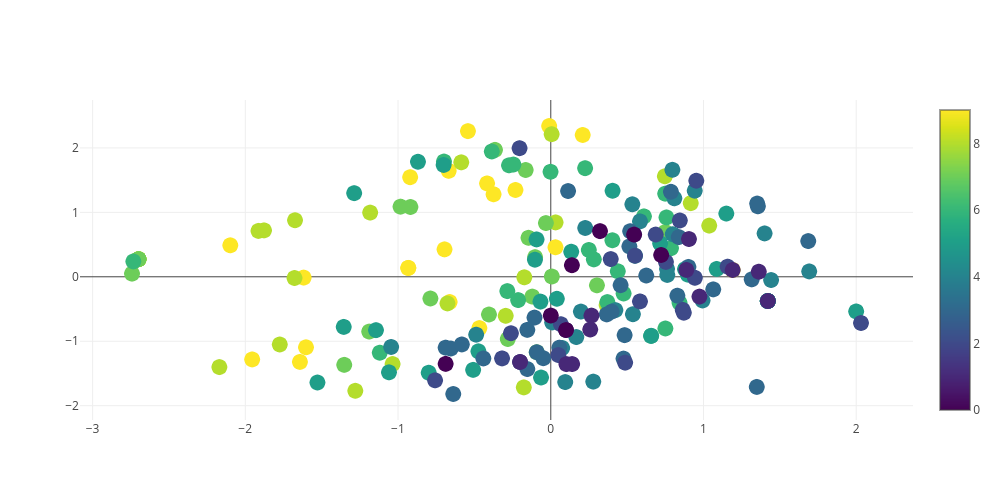

In [6]:
trace = go.Scatter(x = long_std, 
                   y = lat_std, 
                   mode='markers', 
                   marker=dict(
                        size='16',
                        color = y_train,
                        colorscale='Viridis',
                        showscale=True))

plotly.image.save_as([trace], filename="./lat_long_scores.png", width=1000)
Image("./lat_long_scores.png")

### Build the model

In [7]:
# one-hot encoding of the targets
target = utils.to_categorical(y_train, num_classes=10)

In [8]:
# initializers
b_init = keras.initializers.zeros()
w_init = keras.initializers.random_normal(mean=0, stddev=0.05)

# model definition
model = Sequential([
    Dense(512, input_shape=(2,), kernel_initializer=w_init, bias_initializer=b_init),
    Activation('tanh'),
    
    Dense(512, kernel_initializer=w_init, bias_initializer=b_init),
    Activation('tanh'),
    
    Dense(512, kernel_initializer=w_init, bias_initializer=b_init),
    Activation('tanh'),
    
    Dense(10, kernel_initializer=w_init, bias_initializer=b_init),
    Activation('softmax')
])

# tensorboard callback
tb = keras.callbacks.TensorBoard(log_dir='./logs/lr01_ep500', histogram_freq=0, batch_size=180, write_graph=True, 
                                 write_grads=True, write_images=True, embeddings_freq=0, 
                                 embeddings_layer_names=None, embeddings_metadata=None)

# adam optimizer
adam_optimizer = keras.optimizers.adam(beta_1=0.9, beta_2=0.999, lr=0.01, epsilon=10e-8)

# compile the model
model.compile(optimizer=adam_optimizer, loss="categorical_crossentropy", metrics=["categorical_accuracy"])

# fit the model
model.fit(x_train, target, verbose=0, validation_split=0.15, epochs=500, batch_size=180, callbacks=[tb])

### Evaluate and Predict

In [9]:
# build the data for predictions
data_to_predict = data[np.isnan(data["score"])]

# standardize the predictions set
lat_std = (data_to_predict["lat"] - np.mean(data_to_predict["lat"])) / np.std(data_to_predict["lat"])
long_std = (data_to_predict["long"] - np.mean(data_to_predict["long"])) / np.std(data_to_predict["long"])

# put together the dataset
x_to_predict = np.column_stack((lat_std, long_std))

In [10]:
# evaluate the model
X_train, X_test, y_train, y_test = train_test_split(x_train, target, test_size=0.25)
model.evaluate(x=X_test, y=y_test, batch_size=180)

53/53 [==============================] - 0s


[1.7741867303848267, 0.81132078170776367]

In [11]:
prediction = model.predict_classes(x=X_test)
y = np.array(np.where(y_test==1))[1]

32/53 [=================>............] - ETA: 0s

In [12]:
print("Y: {}\n".format(y))
print("Predictions: {}".format(prediction))

Y: [4 9 0 7 6 8 2 3 6 6 5 8 5 4 2 9 2 3 1 5 2 3 6 5 7 7 3 9 6 4 8 8 2 9 4 7 5
 2 3 3 1 3 2 8 3 3 9 0 4 7 5 4 3]

Predictions: [4 9 6 7 6 8 5 3 6 6 5 9 5 4 2 9 2 3 4 5 5 3 6 5 7 7 3 9 6 4 8 8 2 9 4 7 5
 2 3 3 9 3 3 8 3 5 7 5 4 7 5 4 3]


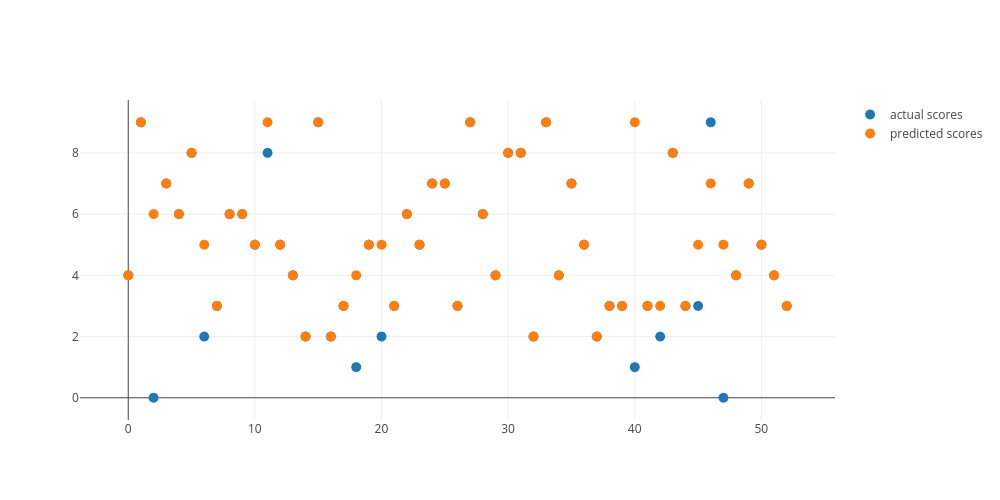

In [13]:
# graph the actual scores and predictions
trace_y = go.Scatter(x=np.arange(len(y)), 
                     y=y, 
                     mode='markers', 
                     marker=dict(
                            size = "10"),
                     name="actual scores")

trace_prediction = go.Scatter(x=np.arange(len(y)), 
                              y=prediction, 
                              mode='markers', 
                              marker=dict(
                                     size = "10"),
                              name="predicted scores")

plotly.image.save_as([trace_y, trace_prediction], filename="./check_predictions.png", width=1000)
Image("./check_predictions.png")

In [14]:
# predict the scores for the schools
predicted_scores = model.predict_classes(x_to_predict)

352/518 [===================>..........] - ETA: 0s

In [15]:
predicted_scores

array([7, 6, 2, 2, 8, 9, 7, 4, 3, 8, 2, 7, 6, 7, 3, 5, 9, 7, 4, 2, 9, 3, 3,
       4, 7, 3, 4, 6, 7, 5, 8, 7, 8, 6, 5, 3, 5, 8, 7, 5, 9, 6, 4, 6, 4, 7,
       7, 2, 3, 7, 3, 3, 9, 9, 8, 3, 4, 8, 5, 2, 2, 6, 6, 6, 4, 6, 4, 7, 3,
       8, 6, 2, 8, 8, 9, 4, 4, 5, 6, 4, 3, 4, 5, 5, 5, 5, 2, 4, 3, 3, 5, 7,
       6, 3, 6, 7, 4, 6, 4, 5, 9, 7, 7, 5, 5, 5, 6, 8, 4, 4, 9, 8, 8, 9, 9,
       6, 4, 4, 3, 6, 9, 4, 5, 5, 6, 3, 9, 5, 6, 3, 8, 2, 5, 4, 4, 3, 6, 6,
       4, 8, 6, 4, 5, 5, 6, 4, 7, 2, 8, 6, 5, 6, 8, 5, 4, 9, 4, 4, 9, 9, 2,
       9, 8, 7, 5, 5, 3, 8, 2, 6, 4, 6, 4, 6, 6, 4, 2, 6, 7, 4, 8, 6, 8, 2,
       5, 6, 3, 7, 6, 8, 2, 7, 8, 2, 7, 3, 6, 7, 4, 7, 7, 5, 7, 8, 5, 4, 7,
       8, 2, 9, 3, 7, 7, 7, 4, 7, 7, 7, 8, 7, 9, 6, 7, 8, 5, 3, 9, 8, 5, 3,
       4, 5, 4, 4, 6, 3, 7, 3, 7, 4, 6, 7, 4, 6, 8, 8, 2, 7, 3, 5, 7, 4, 3,
       9, 9, 9, 5, 5, 7, 5, 6, 7, 9, 5, 5, 5, 6, 9, 5, 2, 5, 2, 4, 8, 6, 3,
       6, 6, 9, 9, 9, 5, 9, 7, 7, 2, 7, 6, 5, 5, 9, 3, 4, 3, 6, 3, 8, 8, 7,
       3, 4,

In [16]:
y_train = data_train["score"]
y = np.append(y_train, predicted_scores)

data["score"] = y

In [17]:
data.to_csv("./austin_school_augmented.csv")